---
title: "Analysis of the Football Database"
format:
  html:
    toc: true
    code-fold: true
    code-summary: "Show the code"
    number-depth: 4
    number-sections: true
---

## Introduction

This is the analysis of the [football data set from Kaggle](https://www.kaggle.com/datasets/prajitdatta/ultimate-25k-matches-football-database-european). The aims of this project are to explore the data set and eventually gain insights on potential betting strategies by building models that predict match outcomes.

### Imports and Options

#### Imports

In [1]:
%reload_ext autoreload
%autoreload 1
# Data handling
import duckdb
import pandas as pd
import numpy as np

# Display
from IPython.display import Markdown, display
from tabulate import tabulate

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch

# Statistics
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from lmfit import Minimizer, Parameters

# Custom
import functions.display_functions as disf
import functions.data_format_functions as dff
from functions.project_functions_classes import Team, MatchPlayers
from functions.project_functions_classes import outcome_guess_prob_dif
from functions.project_functions_classes import outcome_guess_prob_win
from functions.project_functions_classes import classifier_train_prob_win
from functions.project_functions_classes import classifier_train_prob_dif
%aimport functions.display_functions
%aimport functions.project_functions_classes
%aimport functions.data_format_functions

#### Options

##### Pandas and figure options:

In [2]:
pd.set_option("mode.chained_assignment", None)
sns.set()
base_fig_width = 8
base_fig_height = 4.5

##### DuckDB connection and options:

In [3]:
con = duckdb.connect()
con.execute(f"INSTALL sqlite")
con.execute(f"LOAD sqlite")
con.execute(f"SET GLOBAL sqlite_all_varchar=true")
con.execute(f"CALL sqlite_attach('data/database.sqlite')")


##### Fetching table and column names:

In [4]:
tables = con.query(
    f"""--sql
SELECT table_name as 'Table Name',
    COUNT(column_name) AS 'Column Count'
FROM information_schema.columns
GROUP BY table_name
"""
).to_df()

table_columns = con.query(
    f"""--sql
SELECT table_name,
    GROUP_CONCAT(column_name) AS column_names
FROM information_schema.columns
GROUP BY table_name"""
).to_df()
tables["column_names"] = table_columns["column_names"].apply(lambda x: x.split(","))


##### Significance:

In [5]:
alpha = 0.95
significance = 1 - alpha

## Exploratory data analysis

The goal of this section is to familiarize with the data set. Some statistical inference is presented here, but the feature selection for ML models are presented in a separate section and mostly relies on their predictive power.

### Match

The data set includes data on more than 25 thousand matches. Outcomes, betting odds, players, teams, and their starting lineup positions are given. This section explores match related portion of the data set.

##### Preparing Match data:

In [6]:
match_cols = tables.loc[tables["Table Name"] == "Match", "column_names"].to_list()[0]
match_cols_to_remove = ["league_id", "stage", "match_api_id", "cross"]
match_cols = [col for col in match_cols if col not in match_cols_to_remove]
match_raw = con.query(
    f"""--sql
          SELECT {', '.join(match_cols)} FROM Match
          """
).to_df()
match_raw.set_index("id", inplace=True)

#### What in what countries and leagues were the matches played in? By which teams and in which leagues were the most goals scored in?

<iframe width="850" height="638" src="https://lookerstudio.google.com/embed/reporting/7fdf4aab-2c53-454b-8e7e-adc93591e2dd/page/fsdXD" frameborder="0" style="border:0" allowfullscreen></iframe>

The Matches were played in 11 different leagues across 11 different European countries. The most goals per match were scored in Netherlands Eredivisie, while the team that scored the most goals per match was FC Barcelona.

#### Whats the number of matches distribution across the timeline and seasons?

##### Preparing the season and date data:

In [7]:
match_raw["date"] = pd.to_datetime(match_raw["date"])
match_date_count = match_raw.resample("D", on="date").count().cumsum()

seasons = match_raw.groupby("season").agg(
    start=("date", "min"), end=("date", "max"), count=("season", "count")
)
seasons["length"] = seasons["end"] - seasons["start"]

##### Plot:

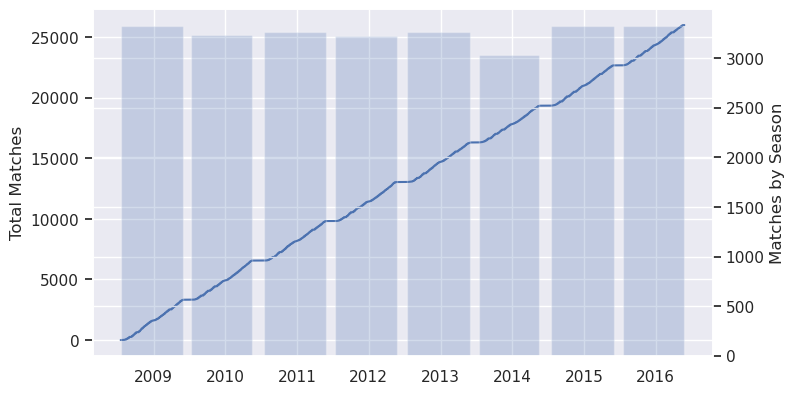

In [8]:
# | label: fig-match_count
# | fig-cap: The cumulative sum of total matches played are represented by the blue line, the bars in the background indicate the number of matches played that season and its time span.
fig_match_count_date, ax_match_count_date = plt.subplots(
    figsize=(base_fig_width, base_fig_height)
)

ax_match_count_date.plot(match_date_count.index, match_date_count["country_id"])
ax_match_count_date_season = ax_match_count_date.twinx()
ax_match_count_date_season.bar(
    x=seasons["start"],
    height=seasons["count"],
    width=seasons["length"],
    align="edge",
    alpha=0.25,
)
ax_match_count_date.set_ylabel("Total Matches")
ax_match_count_date_season.set_ylabel("Matches by Season")

plt.show()


Matches are in the data set were played from 2008 to 2016 in 8 seasons.

#### What is the distribution of goal difference between home and away teams?

##### Calculating the goal difference for each mach:

In [9]:
match_raw[["home_team_goal", "away_team_goal"]] = match_raw[
    ["home_team_goal", "away_team_goal"]
].astype(int)
match_raw["outcome"] = match_raw["home_team_goal"] - match_raw["away_team_goal"]
match_outcomes = match_raw["outcome"].value_counts().to_frame("count")
match_outcomes.reset_index(names=["value"], inplace=True)
match_outcomes["outcome"] = match_outcomes["value"].apply(
    lambda x: "Home Win" if x > 0 else ("Home Loss" if x < 0 else "Tie")
)
match_outcomes["color"] = match_outcomes["value"].apply(
    lambda x: sns.color_palette()[0]
    if x > 0
    else (sns.color_palette()[3] if x < 0 else sns.color_palette()[4])
)


##### Plot:

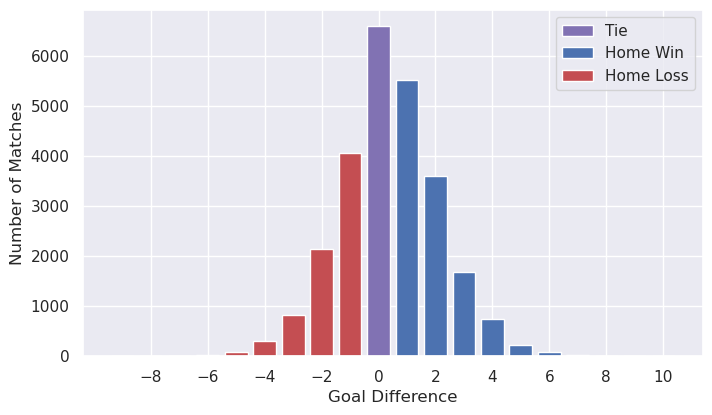

In [10]:
# | label: fig-match_outcomes
# | fig-cap: The number of matches that ended with a specific goal difference.
fig_match_outcomes, ax_match_outcomes = plt.subplots(
    figsize=(base_fig_width, base_fig_height)
)
ax_match_outcomes.bar(
    match_outcomes["value"],
    match_outcomes["count"],
    label=match_outcomes["outcome"],
    color=match_outcomes["color"],
    align="center",
)
handles, labels = ax_match_outcomes.get_legend_handles_labels()
ax_match_outcomes.legend(handles[:3], labels[:3])
ax_match_outcomes.set(xticks=np.arange(start=-8, stop=12, step=2))
ax_match_outcomes.set_ylabel("Number of Matches")
ax_match_outcomes.set_xlabel("Goal Difference")
plt.show()


Visual inspection of the match outcome data suggests that there might be a home advantage. Another important observation is that a large portion of matches end in ties.

#### Is there a home advantage?

##### Chi square test of non-tie matches with the null hypothesis being that there is an equal amount of home wins and away wins:

In [11]:
total_home_wins = match_outcomes.loc[
    match_outcomes["outcome"] == "Home Win", "count"
].sum()
total_away_wins = match_outcomes.loc[
    match_outcomes["outcome"] == "Home Loss", "count"
].sum()
home_advantage_result = stats.chisquare([total_home_wins, total_away_wins])

##### Results:

In [12]:
Markdown(
    f"""
Based on a chi-square test with a confidence level of 95%, the p-value of {home_advantage_result.pvalue:.2e}
strongly suggests that there is a significant home advantage.
{total_home_wins} of all non-tie wins were by the home team,
while only {total_away_wins} matches were won by away teams.
"""
)


Based on a chi-square test with a confidence level of 95%, the p-value of 2.82e-224
strongly suggests that there is a significant home advantage.
11917 of all non-tie wins were by the home team,
while only 7466 matches were won by away teams.


#### What are the different player combinations used?

The data set includes starting lineup positions on the field.

##### Preparing player position combination columns:

In [13]:
# Getting lists of position column names
home_x_cols = [x for x in match_raw.columns.to_list() if "home_player_X" in x]
home_y_cols = [x for x in match_raw.columns.to_list() if "home_player_Y" in x]
away_x_cols = [x for x in match_raw.columns.to_list() if "away_player_X" in x]
away_y_cols = [x for x in match_raw.columns.to_list() if "away_player_Y" in x]

# Changing  the data type to numeric
match_raw[home_x_cols + home_y_cols + away_x_cols + away_y_cols] = match_raw[
    home_x_cols + home_y_cols + away_x_cols + away_y_cols
].apply(pd.to_numeric)

# Putting the home player coordinates into frozensets of (x,y) tuples
match_raw["combinations_home"] = match_raw.apply(
    lambda row: frozenset([(x, y) for x, y in zip(row[home_x_cols], row[home_y_cols])]),
    axis=1,
)

# Changing any values that contain at least a single NaN value to Nan
match_raw["combinations_home"] = match_raw["combinations_home"].apply(
    lambda x: np.nan if any(np.isnan(y) for tup in x for y in tup) else x
)

# Removing frozensets with less than 11 player coordinates
match_raw["combinations_home"] = match_raw["combinations_home"].apply(
    lambda x: x if type(x) == frozenset and len(x) == 11 else np.nan
)

# Putting the away player coordinates into frozensets of (x,y) tuples
match_raw["combinations_away"] = match_raw.apply(
    lambda row: frozenset([(x, y) for x, y in zip(row[away_x_cols], row[away_y_cols])]),
    axis=1,
)

# Removing frozensets with less than 11 player coordinates
match_raw["combinations_away"] = match_raw["combinations_away"].apply(
    lambda x: np.nan if any(np.isnan(y) for tup in x for y in tup) else x
)

# Putting the away player coordinates into frozensets of (x,y) tuples
match_raw["combinations_away"] = match_raw["combinations_away"].apply(
    lambda x: x if type(x) == frozenset and len(x) == 11 else np.nan
)

##### Number of different 11 player combinations:

In [14]:
unique_combos = (
    pd.concat([match_raw["combinations_home"], match_raw["combinations_away"]])
    .value_counts()
    .to_frame(name="count")
    .reset_index(names=["combo"])
)
len(unique_combos)

37

##### Combination distribution on the pitch:

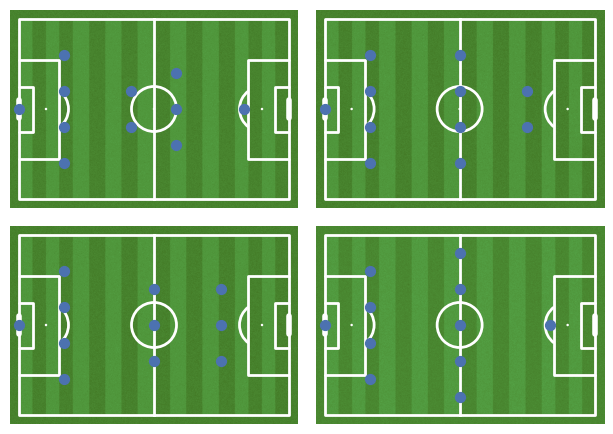

In [15]:
# | label: fig-pitch
# | fig-cap: The four most popular starting lineup position combinations.

# Correcting the position of the goal keeper
unique_combos["scaled_combo"] = unique_combos["combo"].apply(
    lambda x: frozenset((5, 1) if t == (1, 1) else t for t in x)
)

# Scaling to the pitch plot
pitch_y_offset = 4 - dff.scale_num(1, 1, 11, -4, 80)
unique_combos["scaled_combo"] = unique_combos["scaled_combo"].apply(
    lambda x: frozenset(
        (
            dff.scale_num(t[0], 1, 11, 0, 80) + pitch_y_offset,
            dff.scale_num(t[1], 1, 11, 0, 100),
        )
        for t in x
    )
)

pitch = Pitch(
    pitch_color="grass",
    line_color="white",
    stripe=True,
)

fig_pitch, ax_pitch = pitch.draw(
    nrows=2, ncols=2, figsize=(base_fig_width, base_fig_height)
)
ax_pitch = ax_pitch.flatten()

for i, combo in enumerate(unique_combos[:4].iterrows()):
    for pos in combo[1]["scaled_combo"]:
        ax_pitch[i].scatter(
            pos[1],
            pos[0],
            s=50,
            color=sns.color_palette("deep")[0],
        )
plt.tight_layout(w_pad=-6)
plt.show()

### Player attributes

The dataset included a variety of numerical and categorical player attributes, this section presents this portion of the data.

#### What is the player rating and potential distribution?

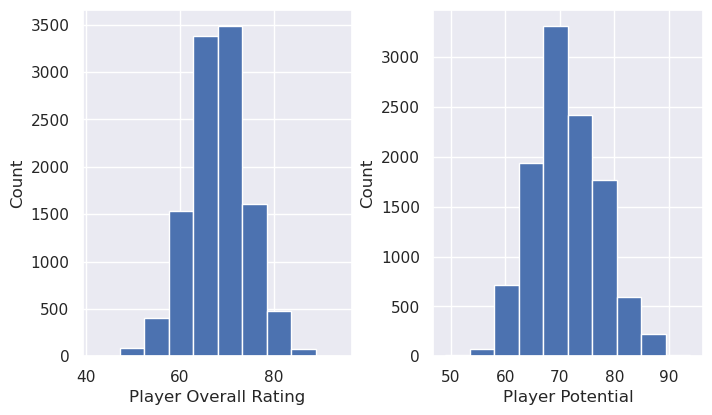

In [16]:
# | label: fig-player_rating_hist
# | fig-cap: The distribution of player overall rating and potential. The latest stats of each player is included in this figure.

# Fetching player attributes with the latest date.
rating_potential = con.query(
    """--sql
SELECT overall_rating,
    potential
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date """
).to_df()
rating_potential.dropna(inplace=True)
rating_potential = rating_potential.astype(int)

# Plot
fig_player_rating_hist, (
    ax_player_rating_hist,
    ax_player_potential_hist,
) = plt.subplots(1, 2, figsize=(base_fig_width, base_fig_height))

rating_potential.hist("potential", ax=ax_player_potential_hist)
rating_potential.hist("overall_rating", ax=ax_player_rating_hist)
disf.axis_titles(ax_player_potential_hist, xtitle="Player Potential", ytitle="Count")
disf.axis_titles(ax_player_rating_hist, xtitle="Player Overall Rating", ytitle="Count")
plt.show()

#### Whats is the foot preference distribution?

In [17]:
con.query(
    f"""--sql
SELECT 
    COUNT(*) AS total,
    SUM(CASE WHEN preferred_foot = 'right' THEN 1 ELSE 0 END) AS right_count,
    SUM(CASE WHEN preferred_foot = 'left' THEN 1 ELSE 0 END) AS left_count
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date"""
).to_df().astype(int).rename(
    columns={
        "total": "Total",
        "right_count": "Right footed players",
        "left_count": "Left footed players",
    }
)

,Total,Right footed players,Left footed players
0,11064,8373,2687


#### Do right and left footed players have a different overall rating?

##### Fetching the data:

In [18]:
player_f_rating = con.query(
    f"""--sql
SELECT  CAST(overall_rating as INT) AS 'Overall Rating', preferred_foot
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date"""
).to_df()

##### T-test:

In [19]:
player_f_rating_levresults = stats.levene(
    player_f_rating.loc[player_f_rating["preferred_foot"] == "right", "Overall Rating"],
    player_f_rating.loc[player_f_rating["preferred_foot"] == "left", "Overall Rating"],
)

player_f_rating_tresults = stats.ttest_ind(
    player_f_rating.loc[player_f_rating["preferred_foot"] == "right", "Overall Rating"],
    player_f_rating.loc[player_f_rating["preferred_foot"] == "left", "Overall Rating"],
    equal_var=player_f_rating_levresults.pvalue > significance,
)
Markdown(
    f"""t-statistic: {round(player_f_rating_tresults.statistic,2)}<br>
         p-val: {round(player_f_rating_tresults.pvalue,2)}<br>
         There {'is a' if player_f_rating_tresults.pvalue < significance else 'is no'} 
         significant difference in overall rating between right and left footed players
         """
)


t-statistic: -0.54<br>
         p-val: 0.59<br>
         There is no 
         significant difference in overall rating between right and left footed players
         

#### What is the distribution of goal keeper attributes?

##### Getting the histogram data for goal keeper diving ability:

In [20]:
goaly_hist_df = (
    con.query(
        f"""--sql
WITH bin_stats AS (
    SELECT (
            (
                MAX(CAST(gk_diving AS INT)) - MIN(CAST(gk_diving AS INT))
            ) / 10
        ) AS bin_size
    FROM Player_Attributes p
        JOIN(
            SELECT player_api_id,
                MAX(date) AS max_date
            FROM Player_attributes
            GROUP BY player_api_id
        ) sub ON p.player_api_id = sub.player_api_id
        AND p.date = sub.max_date
)
SELECT FLOOR(
        CAST(gk_diving AS INT) / (
            SELECT bin_size
            FROM bin_stats
        )
    ) * (
        SELECT bin_size
        FROM bin_stats
    ) AS bin,
    COUNT(*) AS count
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date
GROUP BY bin
ORDER BY bin;
    """
    )
    .to_df()
    .astype(int, errors="ignore")
)

##### Plotting the frequencies:

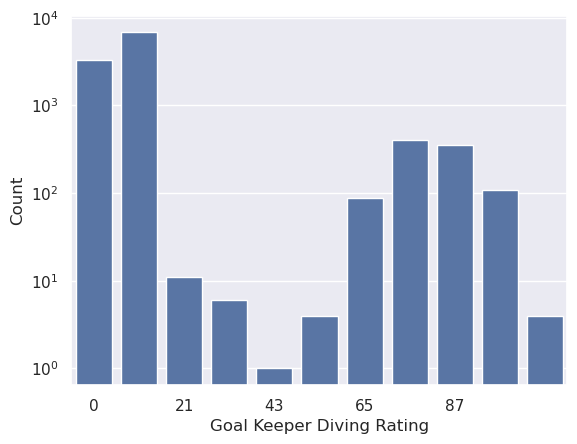

In [21]:
# | label: fig-goaly_stats
# | fig-cap: The distribution of "Goal keeper diving rating across all players in the data set. The latest entry for each player is taken."

fig_goaly_stats, ax_goaly_stats = plt.subplots()
sns.barplot(
    goaly_hist_df, x="bin", y="count", ax=ax_goaly_stats, color=sns.color_palette()[0]
)
ax_goaly_stats.set_xticks(np.arange(0, 10, step=2))
ax_goaly_stats.set_xticklabels(
    np.linspace(goaly_hist_df["bin"].min(), goaly_hist_df["bin"].max(), num=5).astype(
        int
    )
)
ax_goaly_stats.set_yscale("log")
disf.axis_titles(ax=ax_goaly_stats, ytitle="Count", xtitle="Goal Keeper Diving Rating")
plt.show()

The distribution of goalkeeper attributes indicate that there is a split between goalkeepers and regular players.

#### Is there a linear correlation between player overall ratings and their other attributes?

##### Importing all player attributes:

In [22]:
player_attr_raw = con.query(
    f"""--sql
SELECT * FROM Player_Attributes
"""
).to_df()
player_attr_numeric = [
    "overall_rating",
    "potential",
    "crossing",
    "finishing",
    "heading_accuracy",
    "short_passing",
    "volleys",
    "dribbling",
    "curve",
    "free_kick_accuracy",
    "long_passing",
    "ball_control",
    "acceleration",
    "sprint_speed",
    "agility",
    "reactions",
    "balance",
    "shot_power",
    "jumping",
    "stamina",
    "strength",
    "long_shots",
    "aggression",
    "interceptions",
    "positioning",
    "vision",
    "penalties",
    "marking",
    "standing_tackle",
    "sliding_tackle",
    "gk_diving",
    "gk_handling",
    "gk_kicking",
    "gk_positioning",
    "gk_reflexes",
]
player_attr_raw[player_attr_numeric] = player_attr_raw[player_attr_numeric].apply(
    pd.to_numeric
)
player_attr_raw["date"] = pd.to_datetime(player_attr_raw["date"])

##### Calculating and displaying the correlations:

In [23]:
# | label: tbl-rating_att_corr
# | tbl-cap: Pearson's r of overall rating versus other player attributes calculated for all players and goalkeepers separately. The goalkeepers here are defined as having goal keeper diving attribute higher than 50.

player_att_corrs = (
    player_attr_raw[player_attr_numeric]
    .corr()["overall_rating"]
    .to_frame()
    .join(
        player_attr_raw[player_attr_numeric]
        .loc[player_attr_raw[player_attr_numeric]["gk_diving"] > 50]
        .corr()["overall_rating"]
        .to_frame(),
        rsuffix="_goal_keeper",
    )
)


player_att_corrs.style.background_gradient("coolwarm").format("{:.2f}")

,overall_rating,overall_rating_goal_keeper
overall_rating,1.00,1.00
potential,0.77,0.80
crossing,0.36,-0.03
finishing,0.33,-0.03
heading_accuracy,0.31,-0.04
short_passing,0.46,0.12
volleys,0.36,-0.01
dribbling,0.35,-0.03
curve,0.36,-0.03
free_kick_accuracy,0.35,0.01


As seen in table @tbl-rating_att_corr, For all players there are moderate linear correlations between player overall ratings and all attributes except those related to goal keeping. It is the opposite for dedicated goalkeepers.

#### Whats the distribution of attacking and defensive work?

##### Fetching the data:

In [24]:
att_def_df = con.query(
    f"""--sql
SELECT attacking_work_rate, defensive_work_rate
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date"""
).to_df()

##### Plot:

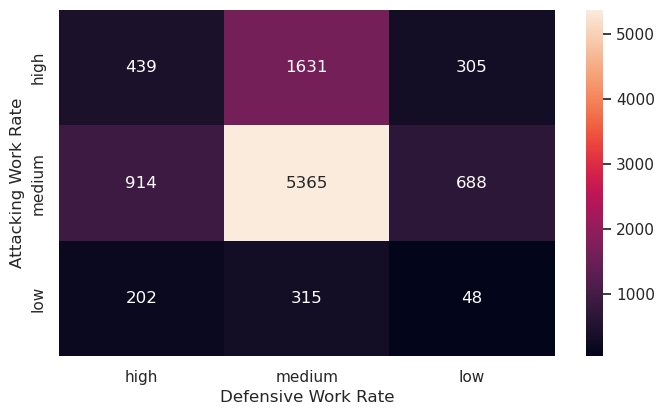

In [25]:
# | label: fig-att_def
# | fig-cap: A heatmap of defensive and attacking work rate of all players. The latest entries for each player were taken.

fig_att_def, ax_att_def = plt.subplots(figsize=(base_fig_width, base_fig_height))
sns.heatmap(
    pd.crosstab(att_def_df["attacking_work_rate"], att_def_df["defensive_work_rate"])[
        ["high", "medium", "low"]
    ].loc[["high", "medium", "low"]],
    annot=True,
    fmt=".0f",
    ax=ax_att_def,
)
disf.axis_titles(
    ax=ax_att_def, xtitle="Defensive Work Rate", ytitle="Attacking Work Rate"
)

The majority of players have both medium attacking and defensive work rates.

### Team Attributes

This section explores the attributes of individual teams that were given in the data set.

##### Fetching the team attributes:

In [26]:
team_attr_raw = con.query(
    f"""--sql
SELECT *
FROM Team_Attributes
"""
).to_df()

#### What is the distribution of Team attributes?

##### Making a list of numeric attributes and fixing data types:

In [27]:
team_numeric_cols = [
    "buildUpPlaySpeed",
    "buildUpPlayDribbling",
    "buildUpPlayPassing",
    "chanceCreationPassing",
    "chanceCreationCrossing",
    "chanceCreationShooting",
    "defencePressure",
    "defenceAggression",
    "defenceTeamWidth",
]
team_categoric_cols = [col + "Class" for col in team_numeric_cols]
team_attr_raw[team_numeric_cols] = team_attr_raw[team_numeric_cols].apply(
    pd.to_numeric, errors="coerce"
)
team_attr_raw["date"] = pd.to_datetime(team_attr_raw["date"])
team_attr_raw.set_index("id", inplace=True)

latest_team_attr = team_attr_raw.loc[team_attr_raw.groupby("team_api_id").date.idxmax()]

##### Plotting numeric attributes and their categories:

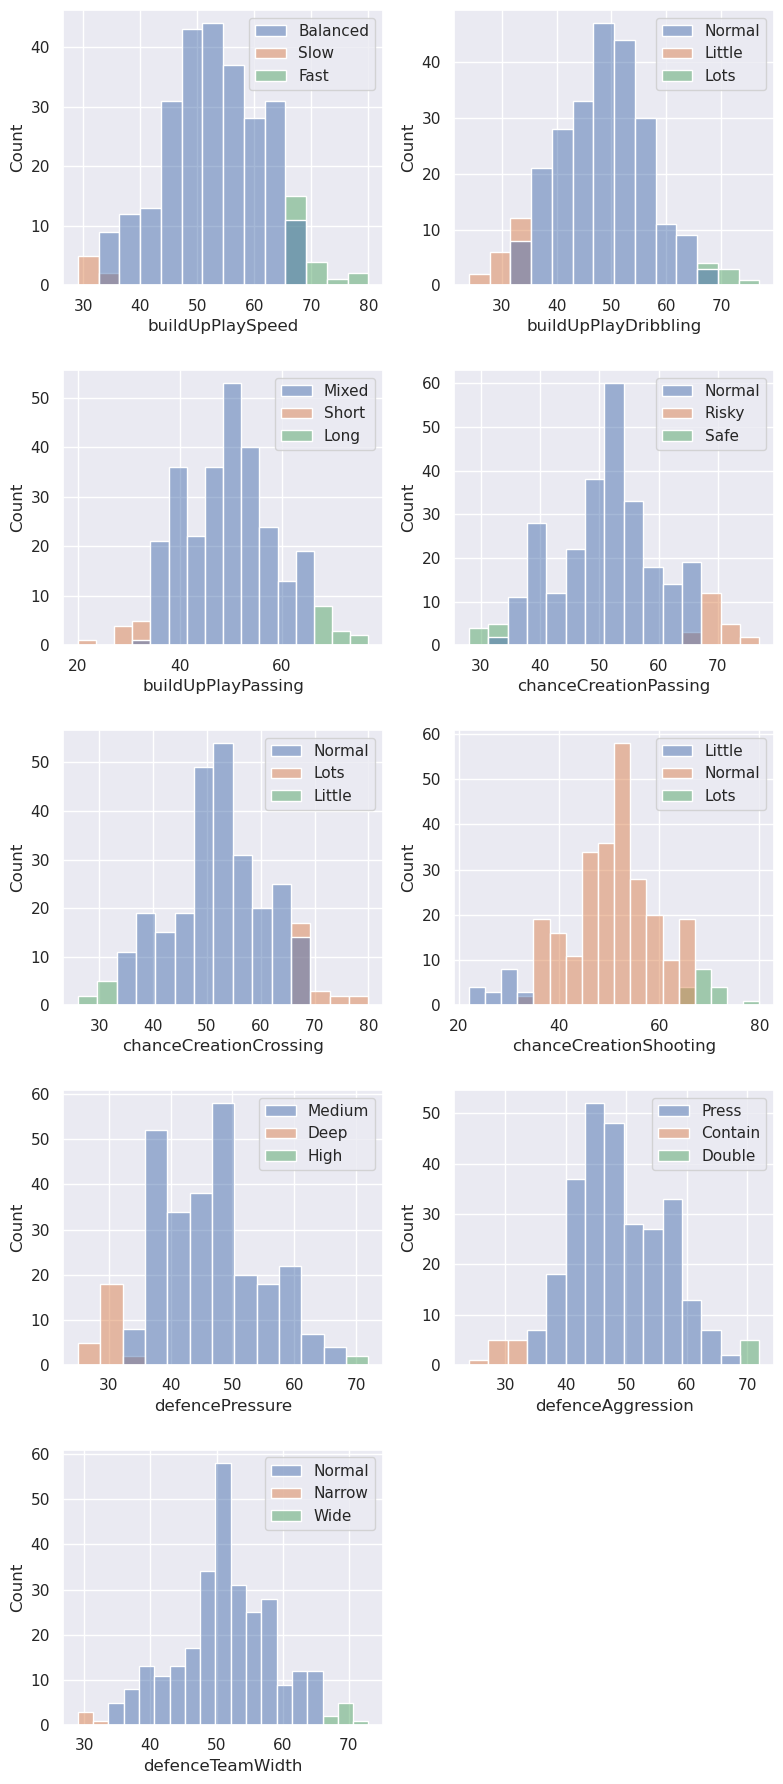

In [28]:
# | label: fig-team_attr
# | fig-cap: Histograms of numeric team attributes. Categories for the same characteristics are also given in the data set, therefore the histograms are split according to those categories.

fig_team_attr, ax_team_attr = plt.subplots(
    5, 2, figsize=(base_fig_width, base_fig_height * 4)
)
ax_team_attr = ax_team_attr.flatten()
for i, attr in enumerate(team_numeric_cols):
    sns.histplot(latest_team_attr, x=attr, hue=attr + "Class", ax=ax_team_attr[i])
    ax_team_attr[i].get_legend().set_title("")

fig_team_attr.delaxes(ax_team_attr[-1])
plt.tight_layout(h_pad=2)
plt.show()

##### Plotting non numeric attributes:

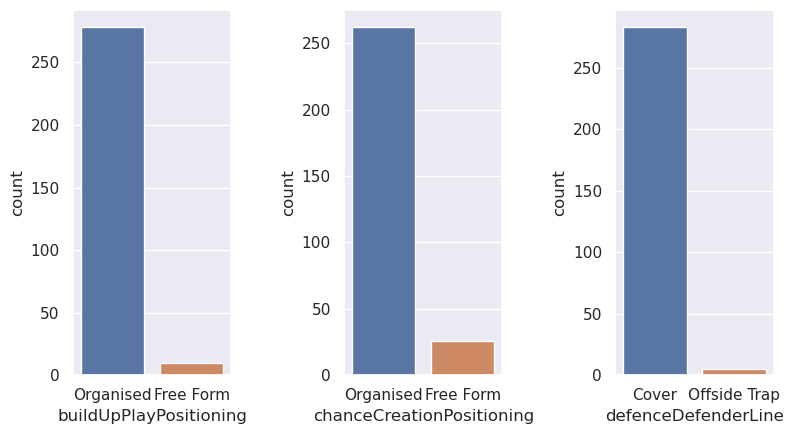

In [29]:
# | label: fig-team_attr_cat
# | fig-cap: The distribution of categorical attributes amongst teams.
team_attr_non_numeric = [
    "buildUpPlayPositioningClass",
    "chanceCreationPositioningClass",
    "defenceDefenderLineClass",
]

fig_team_attr_cat, ax_team_attr_cat = plt.subplots(
    1, 3, figsize=(base_fig_width, base_fig_height)
)
ax_team_attr_cat = ax_team_attr_cat.flatten()

for i, attr in enumerate(team_attr_non_numeric):
    sns.countplot(data=latest_team_attr, x=attr, ax=ax_team_attr_cat[i])
    ax_team_attr_cat[i].set_xlabel(attr[:-5])
plt.tight_layout(w_pad=3)
plt.show()


Team attributes that can be described numerically are given in both numeric and three-category formats as can be seen in @fig-team_attr. Three boolean attributes were also given as seen in @fig-team_attr_cat.

#### Do the numeric team attributes correlate linearly with each other?

In [30]:
disf.get_correlation_pairs(latest_team_attr, 0.3, -0.3).rename(
    {"r-value": "Pearson's r", "feature_pair": "Feature pair"}, axis=1
)

,Pearson's r,Feature pair
0,0.327754,"(buildUpPlaySpeed, chanceCreationPassing)"
2,0.466181,"(defenceAggression, defencePressure)"
3,0.363279,"(defenceTeamWidth, defencePressure)"


Certain defensive attributes seem to have a moderate linear correlation with each other, as well as build up play speed and chance creation passing attributes.

## Feature selection

This section delves into the feature selection process for the final logistic regression model, aimed at predicting whether the home team wins the match. The primary focus of the model lies in achieving high predictive power. As a result, the feature selection heavily relies on the predictive capabilities of different feature sets.

### Starting line-up combinations

Making a copy the match DataFrame with only relevant information:

In [31]:
match_win_df = match_raw[
    [
        "country_id",
        "date",
        "home_team_api_id",
        "away_team_api_id",
        "home_team_goal",
        "away_team_goal",
    ]
]

match_win_df["home_team_win"] = match_win_df.apply(
    lambda x: 1 if x["home_team_goal"] > x["away_team_goal"] else 0, axis=1
)

#### Do combinations influence the match outcome?

##### Adding the combination data:

In [32]:
# Number labels for unique combinations
combo_dict = unique_combos["combo"].to_dict()
combo_dict = {v: k for k, v in combo_dict.items()}

# Adding the combinations from the raw data
match_win_df_combo = pd.merge(
    match_win_df,
    match_raw[["combinations_home", "combinations_away"]],
    left_index=True,
    right_index=True,
)

# Changing the combinations into a single number label
match_win_df_combo[["combinations_home", "combinations_away"]] = match_win_df_combo[
    ["combinations_home", "combinations_away"]
].replace(combo_dict)

# Making a column with the home away combination pairs
match_win_df_combo["combo_home_away"] = match_win_df_combo.apply(
    lambda x: (x["combinations_home"], x["combinations_away"]), axis=1
)
match_win_df_combo["combo_home_away"] = match_win_df_combo["combo_home_away"].apply(
    lambda x: np.nan if np.isnan(x).any() else x
)


##### Chi-squared test with the null hypothesis that home team combination (top 5 combinations only) is not associated to home the home team winning:

In [33]:
comb_h_home_w_con_tab = pd.crosstab(
    match_win_df_combo.loc[
        match_win_df_combo["combinations_home"] <= 5, "home_team_win"
    ],
    match_win_df_combo.loc[
        match_win_df_combo["combinations_home"] <= 5, "combinations_home"
    ],
)
comb_h_home_w_results = stats.chi2_contingency(comb_h_home_w_con_tab)
Markdown(
    f"""Chi-squared statistic: {round(comb_h_home_w_results.statistic,1)}<br>
         p-value: {comb_h_home_w_results.pvalue:.2e}<br>
         The home team combination {'is' if comb_h_home_w_results.pvalue<significance else 'is not'} 
         significantly associated with the home team winning.
         """
)


Chi-squared statistic: 50.8<br>
         p-value: 9.40e-10<br>
         The home team combination is 
         significantly associated with the home team winning.
         

##### Chi-squared test with the null hypothesis that away team combination (top 5 combinations only) is not associated to home the home team winning:

In [34]:
comb_a_home_w_con_tab = pd.crosstab(
    match_win_df_combo.loc[
        match_win_df_combo["combinations_away"] <= 5, "home_team_win"
    ],
    match_win_df_combo.loc[
        match_win_df_combo["combinations_away"] <= 5, "combinations_away"
    ],
)
comb_a_home_w_results = stats.chi2_contingency(comb_a_home_w_con_tab)

Markdown(
    f"""Chi-squared statistic: {round(comb_a_home_w_results.statistic,1)}<br>
         p-value: {comb_a_home_w_results.pvalue:.2e}<br>
         The home team combination 
         {'is' if comb_a_home_w_results.pvalue < significance else 'is not'} 
         significantly associated with the home team winning.
         """
)


Chi-squared statistic: 27.1<br>
         p-value: 5.55e-05<br>
         The home team combination 
         is 
         significantly associated with the home team winning.
         

##### Chi-squared test with the null hypothesis that home-away team combination pair is not associated to home the home team winning:

In [35]:
comb_ha_home_w_con_tab = pd.crosstab(
    match_win_df_combo["combo_home_away"].apply(str),
    match_win_df_combo["home_team_win"],
)
comb_ha_home_w_results = stats.chi2_contingency(comb_ha_home_w_con_tab)

Markdown(
    f"""Chi-squared statistic: {round(comb_ha_home_w_results.statistic,1)}<br>
         p-value: {comb_ha_home_w_results.pvalue:.2e}<br>
         The home-away team combination pair 
         {'is' if comb_ha_home_w_results.pvalue<significance else 'is not'} 
         significantly associated with the home team winning.
         """
)


Chi-squared statistic: 756.2<br>
         p-value: 3.67e-05<br>
         The home-away team combination pair 
         is 
         significantly associated with the home team winning.
         

##### Home team combination-match outcome heatmap:

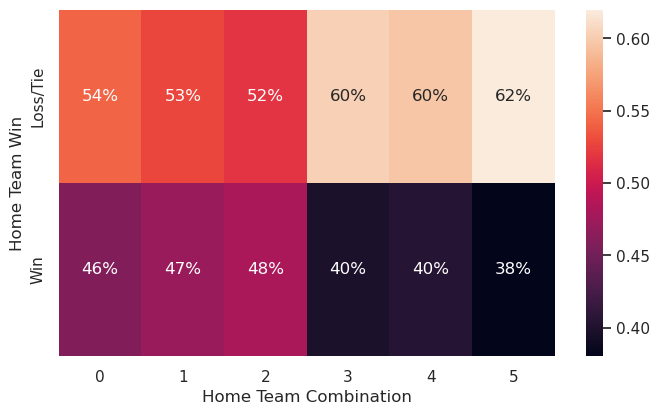

In [36]:
# | label: fig-combo_heatmap
# | fig-cap: Heatmap of six most popular home team starting lineup combinations versus match outcome.

fig_combo_contingency, ax_combo_contingency = plt.subplots(
    figsize=(base_fig_width, base_fig_height)
)
sns.heatmap(
    comb_h_home_w_con_tab.apply(lambda x: x.div(x.sum(), axis=0)),
    fmt=".0%",
    annot=True,
    ax=ax_combo_contingency,
)
disf.axis_titles(
    ax=ax_combo_contingency, xtitle="Home Team Combination", ytitle="Home Team Win"
)

ax_combo_contingency.set_xticklabels(np.arange(0,6))
ax_combo_contingency.set_yticklabels(["Loss/Tie", "Win"])
plt.show()

From the statistical analysis we can say that the starting lineup combinations do influence the match outcome. An example of this is illustrated in @fig-combo_heatmap, where it can be seen that certain combinations such as combination 2 have a higher win percentage than others such as combination 5.

#### Can the combinations be used to predict match outcome?

Due to the categoric nature of the combination data and the number of different categories the random forest model was chosen to test the predictive power of this feature set. The Model is built by using both home team and away team starting lineup combinations.

##### Building the random forest model and making predictions:

In [37]:
match_win_df_combo.dropna(inplace=True)
home_win_target = match_win_df_combo["home_team_win"]
home_win_team_features = match_win_df_combo[["combinations_home", "combinations_away"]]
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_team_features, home_win_target, test_size=0.33, random_state=1
)

# Create and fit the logistic regression model
logit_model = RandomForestClassifier()
result = logit_model.fit(X_train, y_train)

# Predict using the trained model
predictions = result.predict(X_test)

##### Classification report:

In [38]:
print(classification_report(y_test, predictions.round()))

              precision    recall  f1-score   support

           0       0.55      0.82      0.66      4360
           1       0.48      0.20      0.29      3607

    accuracy                           0.54      7967
   macro avg       0.52      0.51      0.47      7967
weighted avg       0.52      0.54      0.49      7967



##### Outcome skew in the test set:

In [39]:
y_test.value_counts(normalize=True).to_frame(name="Fraction")

,Fraction
0,0.547257
1,0.452743


##### Receiver operating characteristic curve:

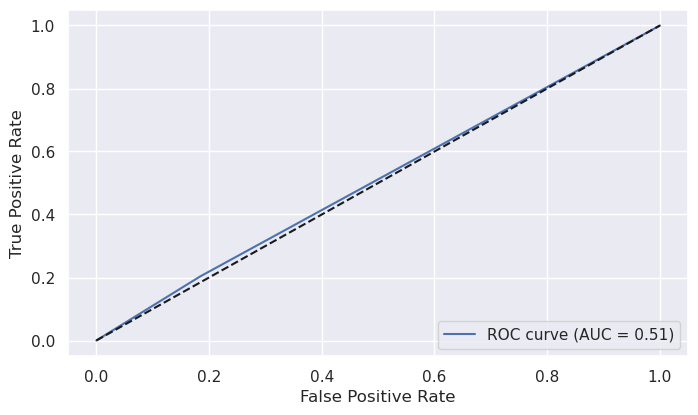

In [40]:
# | label: fig-combo_roc
# | fig-cap: Receiver operating characteristic curve of the home-win predictions made by the random forest model trained on team starting lineup combinations.

fpr, tpr, thresholds = roc_curve(y_test, predictions.round())
auc_score = roc_auc_score(y_test, predictions.round())

fig_combo_roc, ax_combo_roc = plt.subplots(figsize=(base_fig_width, base_fig_height))
ax_combo_roc.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % auc_score)
ax_combo_roc.plot([0, 1], [0, 1], "k--")  # Random guessing line
ax_combo_roc.set_xlabel("False Positive Rate")
ax_combo_roc.set_ylabel("True Positive Rate")
ax_combo_roc.legend(loc="lower right")
plt.show()

The random forest model based on the home team and away team starting line-up combinations predicted the game outcome with 54% accuracy. This value does not be the underlying outcome data skew and barely beats random guessing as seen from the ROC curve (@fig-combo_roc) therefore these features are not included in the final model.

### Team Attributes

#### Preparing the features

In the dataset, team attributes have undergone multiple updates over time, likely derived from the respective teams' performances in various matches, possibly even including the matches contained within this dataset. Consequently, we must exercise caution not to incorporate attributes updated after each match occurrence, as doing so could introduce match outcome leakage into our feature set, which can significantly bias the model and compromise its ability to generalize to new, unseen data. To ensure the integrity and validity of our predictive model, we must strictly adhere to using only those team attributes that were available up until the time of each match without incorporating any post-match updates.

##### Importing team attributes into a dataframe:

In [41]:
team_attr_raw = con.query(
    """--sql
SELECT *
FROM Team_attributes
"""
).to_df()

team_attr_raw["date"] = pd.to_datetime(team_attr_raw["date"])
team_attr_raw[team_numeric_cols] = team_attr_raw[team_numeric_cols].apply(pd.to_numeric)

##### Creating Team class objects for each team:

In [42]:
unique_team_ids = [
    i[0]
    for i in con.query(
        """--sql
SELECT DISTINCT team_api_id
FROM Team_attributes
"""
    ).fetchall()
]
teams = {}

for team in unique_team_ids:
    teams[team] = Team(team)
    teams[team].get_data(team_attr_raw)

##### Removing matches with teams that have no attributes:

In [43]:
match_win_df_team = match_win_df[
    match_win_df.index.isin(match_win_df_combo.index)
]  # not using rows with missing combination data
match_win_df_team = match_win_df[
    ~match_win_df["away_team_api_id"].isin(
        set(unique_team_ids).symmetric_difference(
            match_win_df["away_team_api_id"].unique()
        )
    )
]

match_win_df_team = match_win_df_team[
    ~match_win_df_team["home_team_api_id"].isin(
        set(unique_team_ids).symmetric_difference(
            match_win_df_team["home_team_api_id"].unique()
        )
    )
]


##### Getting the latest team attributes by match date using the Team class:

In [44]:
team_attributes_home = {}
for index in match_win_df_team.index:
    team_attributes_home[index] = teams[
        match_win_df_team.at[index, "home_team_api_id"]
    ].get_latest_entry(match_win_df_team.loc[index, "date"], team_numeric_cols)

team_attributes_away = {}
for index in match_win_df_team.index:
    team_attributes_away[index] = teams[
        match_win_df_team.at[index, "away_team_api_id"]
    ].get_latest_entry(match_win_df_team.loc[index, "date"], team_numeric_cols)

match_win_df_team = match_win_df_team.join(
    pd.concat(
        list(team_attributes_home.values()), keys=team_attributes_home.keys()
    ).droplevel(1),
    rsuffix="_home",
)

match_win_df_team = match_win_df_team.join(
    pd.concat(
        list(team_attributes_away.values()), keys=team_attributes_away.keys()
    ).droplevel(1),
    rsuffix="_away",
)


##### Dropping matches where teams do not have date relevant attributes:

In [45]:
match_win_df_team.dropna(inplace=True)

##### Number of matches left:

In [46]:
len(match_win_df_team)

5562

##### Lineup combination summary

A custom class object called "Team" has been developed, wherein a new instance of the Team class is created for each team in the dataset. This class effectively stores all attribute entries associated with a specific team. Additionally, the class includes a method that, given a specific date and a list of columns, enables retrieval of the latest features that were entered before the specified date.

Using this Team class, relevant date-specific attributes for both the home and away teams were incorporated for each match in the dataset. However, Only five and a half thousand matches out of the total dataset had date-relevant team attributes.

#### Logistic regression with all home and away team attributes

##### Model training and prediction:

In [47]:
cols_to_drop = [
    "date",
    "country_id",
    "home_team_api_id",
    "away_team_api_id",
    "home_team_goal",
    "away_team_goal",
    "home_team_win",
]

home_win_target_team = match_win_df_team["home_team_win"]
home_win_team_features = match_win_df_team.drop(columns=cols_to_drop)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_team_features, home_win_target_team, test_size=0.33, random_state=1
)

# Scaling the data
team_feat_scaler = StandardScaler()
X_train = team_feat_scaler.fit_transform(X_train)
X_test = team_feat_scaler.fit_transform(X_test)

# Create and fit the logistic regression model
logit_model_team_raw = sm.Logit(y_train, sm.add_constant(X_train))
result_team_raw = logit_model_team_raw.fit()

# Predict using the trained model
predictions_team_raw = result_team_raw.predict(sm.add_constant(X_test))



#### Classification report:

In [48]:
print(classification_report(y_test, predictions_team_raw.round()))

              precision    recall  f1-score   support

           0       0.59      0.78      0.67      1010
           1       0.55      0.33      0.41       826

    accuracy                           0.58      1836
   macro avg       0.57      0.56      0.54      1836
weighted avg       0.57      0.58      0.56      1836



##### Test set outcome skew:

In [48]:
y_test.value_counts(normalize=True).to_frame(name="Fraction")

,Fraction
0,0.550109
1,0.449891


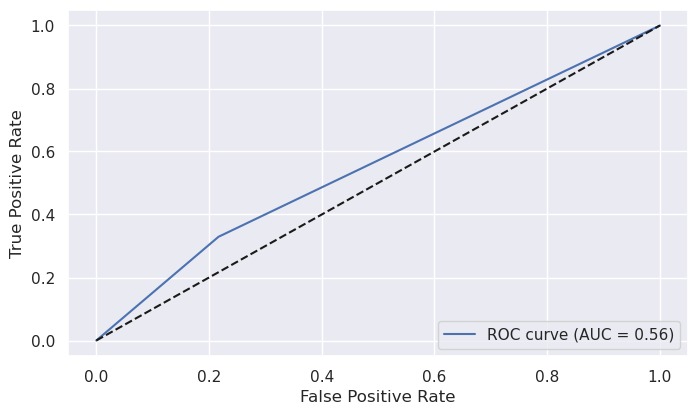

In [84]:
# | label: fig-roc_team_all
# | fig-cap: Receiver operating characteristic curve of the home-win predictions made by a logistic regression model trained on all unmodified team attributes.
 
fpr, tpr, thresholds = roc_curve(y_test, predictions_team_raw.round())
auc_score = roc_auc_score(y_test, predictions_team_raw.round())

fig_roc_team_all, ax_roc_team_all = plt.subplots(figsize=(base_fig_width, base_fig_height))
ax_roc_team_all.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % auc_score)
ax_roc_team_all.plot([0, 1], [0, 1], "k--")  # Random guessing line
ax_roc_team_all.set_xlabel("False Positive Rate")
ax_roc_team_all.set_ylabel("True Positive Rate")
ax_roc_team_all.legend(loc="lower right")
plt.show()

##### Model coefficients:

In [63]:
# | label: tbl-team_all
# | tbl-cap: Logistic regression model coefficients obtained by fitting the model using all team attributes without modification.
params_team_all = result_team_raw.params[1:].to_frame(name="Coefficient")
params_team_all["p-value"] = result_team_raw.pvalues[1:].values
params_team_all.index = match_win_df_team.drop(columns=cols_to_drop).columns
params_team_all.sort_values("Coefficient", ascending=False).style.applymap(
    lambda value: disf.rb_cell_highlight(value, threshold=significance, higher=False),
    subset="p-value",
)

,Coefficient,p-value
chanceCreationCrossing,0.152056,0.000039
defencePressure,0.144163,0.000423
defenceAggression,0.108681,0.005694
buildUpPlayPassing_away,0.102034,0.005645
chanceCreationShooting,0.058222,0.103961
chanceCreationPassing,0.054869,0.148477
chanceCreationPassing_away,0.036955,0.326063
buildUpPlaySpeed_away,0.000000,nan
buildUpPlayDribbling,-0.009078,0.805382
buildUpPlayDribbling_away,-0.010104,0.781839


##### Team unmodified attribute summary

The logistic regression model, utilizing 18 team attributes, achieved a 58% accuracy in predicting game outcomes, slightly surpassing the dataset's natural skew. This observation is further supported by the ROC curve, which yielded an area under the curve (AUC) of 0.56. Since we are specifically interested in predicting home winning matches, the model's precision for home wins was 0.55, while the recall was only 0.33. This outcome is favorable for betting strategies, as we prioritize precise positive predictions and have the option not to place a bet.

The significance analysis of the logistic regression model revealed that the top 4 largest coefficients and the lowest coefficients were deemed statistically significant, while those coefficients falling in between were considered insignificant.

Despite these results, the model's performance-to-feature ratio is not satisfactory. To address this, we will focus on reducing the number of features by utilizing the differences of these attributes between home and away teams.

#### Logistic regression with home-away team attribute differences

##### Training the model and predictions:

In [68]:
home_win_team_features_dif = match_win_df_team.drop(columns=cols_to_drop)
home_win_team_features_dif = (
    home_win_team_features_dif[team_numeric_cols].values
    - home_win_team_features_dif[[col + "_away" for col in team_numeric_cols]].values
)

team_feat_names = [i + "_diff" for i in team_numeric_cols]
home_win_team_features_dif = pd.DataFrame(
    home_win_team_features_dif,
    columns=team_feat_names,
    index=home_win_target_team.index,
)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_team_features_dif, home_win_target_team, test_size=0.33, random_state=1
)

# Scale the data
team_feat_ratio_scaler = StandardScaler()
X_train = team_feat_ratio_scaler.fit_transform(X_train)
X_test = team_feat_ratio_scaler.fit_transform(X_test)

# Create and fit the logistic regression model
logit_model_team_dif = sm.Logit(y_train, sm.add_constant(X_train))
result_team_dif = logit_model_team_dif.fit()

# Predict using the trained model
predictions_team_dif = result_team_dif.predict(sm.add_constant(X_test))

Optimization terminated successfully.
         Current function value: 0.672126
         Iterations 4


##### Classification report:

In [69]:
print(classification_report(y_test, predictions_team_dif.round()))

              precision    recall  f1-score   support

           0       0.59      0.79      0.68      1010
           1       0.56      0.32      0.41       826

    accuracy                           0.58      1836
   macro avg       0.57      0.56      0.54      1836
weighted avg       0.57      0.58      0.55      1836



##### Model coefficients:

In [71]:
# | label: tbl-team_dif
# | tbl-cap: Logistic regression model coefficients obtained by fitting the model using the differences of team attributes.
params_team_all = result_team_dif.params[1:].to_frame(name="Coefficient")
params_team_all["p-value"] = result_team_dif.pvalues[1:].values
params_team_all.index = team_feat_names
params_team_all.sort_values("Coefficient", ascending=False).style.applymap(
    lambda value: disf.rb_cell_highlight(value, threshold=significance, higher=False),
    subset="p-value",
)

,Coefficient,p-value
chanceCreationCrossing_diff,0.153614,0.000030
defenceAggression_diff,0.152408,0.000104
defencePressure_diff,0.149047,0.000379
chanceCreationShooting_diff,0.068049,0.052230
chanceCreationPassing_diff,0.011143,0.766147
buildUpPlayDribbling_diff,0.003255,0.925469
defenceTeamWidth_diff,-0.027599,0.448482
buildUpPlaySpeed_diff,-0.052334,0.159906
buildUpPlayPassing_diff,-0.155055,0.000062


Reducing the number of features in half by calculating the difference between home and away teams did not compromise the predictive power of the model. Furthermore only four features were determined to be significant, as expected most of these were positive (diiferences in chance creation crossing, defence aggression, and defence pressiure), yet one negative feature "build up play passing" was also significant.

##### Building a model with only significant features:

In [82]:
# Selecting significant features based on previous model
significant_team_features = params_team_all.loc[
    params_team_all["p-value"] < significance
].index.to_list()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_team_features_dif[significant_team_features],
    home_win_target_team,
    test_size=0.33,
    random_state=1,
)

# Scale the data
team_feat_ratio_scaler = StandardScaler()
X_train = team_feat_ratio_scaler.fit_transform(X_train)
X_test = team_feat_ratio_scaler.fit_transform(X_test)

# Create and fit the logistic regression model
logit_model_team_dif = sm.Logit(y_train, sm.add_constant(X_train))
result_team_dif = logit_model_team_dif.fit()

# Predict using the trained model
predictions_team_dif = result_team_dif.predict(sm.add_constant(X_test))

Optimization terminated successfully.
         Current function value: 0.672929
         Iterations 4


In [80]:
print(classification_report(y_test, predictions_team_dif.round()))

              precision    recall  f1-score   support

           0       0.59      0.81      0.68      1010
           1       0.58      0.32      0.41       826

    accuracy                           0.59      1836
   macro avg       0.58      0.56      0.55      1836
weighted avg       0.58      0.59      0.56      1836



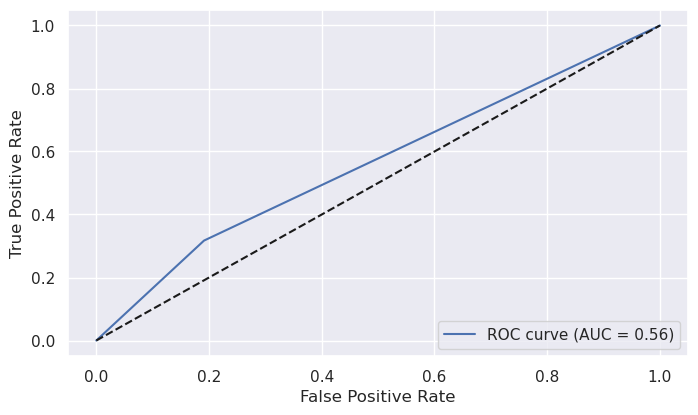

In [85]:
# | label: fig-roc_team_dif
# | fig-cap: Receiver operating characteristic curve of the home-win predictions made by a logistic regression model trained on significant team attribute differences.
 
fpr, tpr, thresholds = roc_curve(y_test, predictions_team_dif.round())
auc_score = roc_auc_score(y_test, predictions_team_dif.round())

fig_roc_team_dif, ax_roc_team_dif = plt.subplots(figsize=(base_fig_width, base_fig_height))
ax_roc_team_dif.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % auc_score)
ax_roc_team_dif.plot([0, 1], [0, 1], "k--")  # Random guessing line
ax_roc_team_dif.set_xlabel("False Positive Rate")
ax_roc_team_dif.set_ylabel("True Positive Rate")
ax_roc_team_dif.legend(loc="lower right")
plt.show()

#### Team attribute summary

By calculating the differences in team attributes and subsequently selecting only the significant differences, the model's performance was not compromised. On the contrary, it even exhibited an increase of one percentage point in accuracy and precision when predicting home team winning matches. As a result, these four significant team attribute differences will be retained and utilized in the final model.

### Player Attributes

To avoid outcome data leakage and address the dynamic nature of player attributes and team composition, a custom class called "MatchPlayers" was implemented. This class includes a subclass named "Player" and incorporates several methods to handle the data preparation challenges effectively.

Since player attributes may undergo updates over time, it is essential to ensure that the model does not have access to future information when making predictions. To achieve this, the "MatchPlayers" class ensures that player attribute data is appropriately partitioned and processed, preventing any leakage of information from future matches.

Additionally, teams consist of 11 different players, and their compositions can change over time. Managing these variations is vital for accurate predictions. The class efficiently handles team composition changes, allowing for proper data alignment and processing during model training and evaluation.

Furthermore, the inclusion of goalkeepers presents an additional complexity, as they possess a distinct set of attributes compared to other players as was shown in @tbl-rating_att_corr. The "MatchPlayers" class addresses this issue by appropriately differentiating and handling goalkeeper attributes to ensure their relevance in the model without compromising overall data integrity.

Moreover, the "MatchPlayers" class also includes functions to export different sets of features, as well as their transformed variants, allowing for flexible feature selection and manipulation during the model building process. This feature further enhances the adaptability and utility of the custom class in preparing the data for predictive modeling.

##### Getting the date relevant attributes of each match player using the MatchPlayers class Player subclass and their functions:
10+ min processing time warning! 

In [54]:
# # only using rows with team attributes
# match_win_df_player = match_win_df.copy()[
#     match_win_df.index.isin(match_win_df_team.index)
# ]

# # Creating MatchPlayers objects for each match
# match_players_series = {}
# for i in match_win_df_player.index:
#     match_players_series[i] = MatchPlayers()
# match_players_series = pd.Series(match_players_series, name="match_players")
# match_win_df_player = match_win_df_player.join(match_players_series)

# # Using the MatchPlayers methods and the player subclass and it's methods to store date
# # player attribute data for each match
# for index, row in match_raw[match_raw.index.isin(match_win_df_player.index)].iterrows():
#     match_win_df_player.at[index, "match_players"].get_data(row)
#     match_win_df_player.at[index, "match_players"].get_player_positions()
#     match_win_df_player.at[index, "match_players"].get_player_ids()
#     match_win_df_player.at[index, "match_players"].home_players[
#         "goaly"
#     ].get_player_attributes(player_attr_raw, row["date"])
#     match_win_df_player.at[index, "match_players"].away_players[
#         "goaly"
#     ].get_player_attributes(player_attr_raw, row["date"])
#     for player in match_win_df_player.at[index, "match_players"].home_players[
#         "players"
#     ]:
#         player.get_player_attributes(player_attr_raw, row["date"])
#     for player in match_win_df_player.at[index, "match_players"].away_players[
#         "players"
#     ]:
#         player.get_player_attributes(player_attr_raw, row["date"])


##### Optional code for saving and loading sorted match data for further use:

In [87]:
import pickle

# with open('match_win_df_player.pkl', 'wb') as file:
#     pickle.dump(match_win_df_player, file)

with open("match_win_df_player.pkl", "rb") as file:
    match_win_df_player = pickle.load(file)

By employing the custom class "MatchPlayers" with its "Player" subclass and various methods, the data preparation challenges related to player attributes, team compositions, and goalkeeper attributes were effectively overcome, providing a robust foundation for building an accurate predictive model.

#### Logistic regression using all attributes

Due to the large number of different players and their attributes in a single match, the resulting feature set from the "MatchPlayers" class can consist of up to 770 different features. However, with only around five thousand samples available, this leads to an unbalanced feature-to-sample ratio in our training set, necessitating feature reduction.

In the first iteration of the model, all possible player attributes without any modifications were utilized. These attributes were then used to train a logistic regression model to predict whether the home team wins the match. To mitigate potential overfitting and reduce the inclusion of less important features, the fitting function employed regularization with an alpha value of 0.1.

##### Exporting all player attributes:

In [96]:
# Export all player attributes for each mach in to a dictionary
player_att_dict = {}
for i in match_win_df_player.index:
    player_att_dict[i] = match_win_df_player.at[
        i, "match_players"
    ].export_player_attributes(player_attr_numeric, how="all")

# Merging with the match dataframe
match_win_players = pd.DataFrame.from_dict(player_att_dict, orient="index").join(
    match_win_df["home_team_win"]
)

# Dropping rows with missing values
match_win_players.dropna(inplace=True)

# In some cases missing attributes were returned as empty dictionaries, dropping these rows
match_win_players = match_win_players[
    match_win_players.apply(
        lambda x: False if dict in [type(i) for i in x.values] else True, axis=1
    )
]

##### Logistic Regression with all player attributes:

In [97]:
home_win_target_player = match_win_players["home_team_win"]
home_win_features_player = match_win_players.drop(columns="home_team_win")

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_features_player, home_win_target_player, test_size=0.33, random_state=1
)

# Scaling the data
player_feat_scaler = StandardScaler()
X_train = player_feat_scaler.fit_transform(X_train)
X_test = player_feat_scaler.fit_transform(X_test)

# Create and fit the logistic regression model
logit_model_player_all = sm.Logit(y_train, sm.add_constant(X_train))
result_player_all = logit_model_player_all.fit_regularized(
    method="l1_cvxopt_cp", alpha=0.1, disp=0
)

# Predict using the trained model
predictions_player_all = result_player_all.predict(sm.add_constant(X_test))

##### Classification report:

In [98]:
print(classification_report(y_test, predictions_player_all.round()))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       933
           1       0.52      0.52      0.52       736

    accuracy                           0.58      1669
   macro avg       0.57      0.57      0.57      1669
weighted avg       0.58      0.58      0.58      1669



##### Area under the receiver operating characteristic curve:

In [107]:
roc_auc_score(y_test, predictions_player_all.round()).round(2)

0.57

##### What is the test data set skew?

In [99]:
y_test.value_counts(normalize=True).to_frame("Fraction")

,Fraction
0,0.559017
1,0.440983


##### Coefficients and their p-values:

In [112]:
# Displaying the coefficients and their p-values
params_player_all = result_player_all.params[1:].to_frame(name="Coefficient")
params_player_all["p-value"] = result_player_all.pvalues[1:].values
params_player_all.index = home_win_features_player.columns
display(Markdown("Largest positive coefficients:"))
display(
    params_player_all.sort_values("Coefficient", ascending=False)
    .head()
    .style.applymap(
        lambda value: disf.rb_cell_highlight(
            value, threshold=significance, higher=False
        ),
        subset="p-value",
    )
    .format("{:.3f}")
)
display(Markdown("Largest negative coefficients:"))
display(
    params_player_all.sort_values("Coefficient", ascending=False)
    .tail()
    .style.applymap(
        lambda value: disf.rb_cell_highlight(
            value, threshold=significance, higher=False
        ),
        subset="p-value",
    )
    .format("{:.3f}")
)

Largest positive coefficients:

,Coefficient,p-value
overall_rating_A_6,0.503,0.007
marking_A_2,0.458,0.004
overall_rating_H_2,0.425,0.172
ball_control_A_10,0.388,0.010
sliding_tackle_H_gk,0.324,0.063


Largest negative coefficients:

,Coefficient,p-value
overall_rating_H_gk,-0.500,0.562
sliding_tackle_H_5,-0.507,0.006
overall_rating_H_10,-0.523,0.047
overall_rating_A_2,-0.606,0.211
overall_rating_A_gk,-1.033,0.236


The model utilizing all player attributes achieved a similar accuracy of 58% compared to the one trained on team attributes, but it involved the use of a substantially higher number of features (770 attributes). Furthermore, this model exhibited a higher recall, which compromises potential profits from betting due to increased false positives.

Given the large number of features relative to the limited number of samples, even when employing lasso regression to penalize large coefficients, some coefficients with significant magnitudes had p-values above the significance level. As a result, it becomes evident that to enhance the model's predictive power and simplicity, it is necessary to reduce the number of features.

#### Logistic regression using the differences of player attributes:

The most straightforward approach to feature reduction is employed here by utilizing the differences in attributes between home and away players instead of considering attributes from all players individually. By adopting this method, the number of features is effectively reduced by half.

To address the challenge of distinguishing the importance of players in specific positions, a more generalized approach is implemented. Instead of using separate attribute differences for each player, the average of all non-goalkeeper players' attributes is utilized. This further reduces the number of features significantly, resulting in a final set of 70 features from the initial 770.

This reduction in the number of features streamlines the model, making it more interpretable and computationally efficient while retaining relevant information for predicting home team wins in football matches.

##### Fetching relevant differences of player attributes:

In [133]:
player_att_dict = {}
for i in match_win_df_player.index:
    player_att_dict[i] = match_win_df_player.at[
        i, "match_players"
    ].export_player_attributes(player_attr_numeric, how="avg_diff")

match_win_players = pd.DataFrame.from_dict(player_att_dict, orient="index").join(
    match_win_df["home_team_win"]
)

# Dropping rows with missing values
match_win_players.dropna(inplace=True)

# In some cases missing attributes were returned as empty dictionaries, dropping these rows
match_win_players = match_win_players[
    match_win_players.apply(
        lambda x: False if dict in [type(i) for i in x.values] else True, axis=1
    )
]

##### Logistic regression model training and predictions:

In [137]:
home_win_target_playerdif = match_win_players["home_team_win"]
home_win_features_playerdif = match_win_players.drop(columns="home_team_win")

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_features_playerdif,
    home_win_target_playerdif,
    test_size=0.33,
    random_state=1,
)

# Scaling the data
player_feat_scaler = StandardScaler()
X_train = player_feat_scaler.fit_transform(X_train)
X_test = player_feat_scaler.fit_transform(X_test)

# Create and fit the logistic regression model
logit_model_player_dif = sm.Logit(y_train, sm.add_constant(X_train))
result_player_dif = logit_model_player_dif.fit_regularized(
    method="l1_cvxopt_cp", alpha=0.1, disp=0
)

# Predict using the trained model
predictions_player_dif = result_player_dif.predict(sm.add_constant(X_test))

##### Classification report:

In [138]:
print(classification_report(y_test, predictions_player_dif.round()))

              precision    recall  f1-score   support

           0       0.66      0.73      0.70       933
           1       0.61      0.52      0.56       736

    accuracy                           0.64      1669
   macro avg       0.64      0.63      0.63      1669
weighted avg       0.64      0.64      0.64      1669



##### Area under the receiver operating characteristic curve:

In [139]:
roc_auc_score(y_test, predictions_player_dif.round()).round(2)

0.63

##### The most important coefficients and their p-values

In [140]:
params_player_dif = result_player_dif.params[1:].to_frame(name="Coefficient")
params_player_dif["p-value"] = result_player_dif.pvalues[1:].values
params_player_dif.index = home_win_features_playerdif.columns
display(Markdown("Largest positive coefficients:"))
display(params_player_dif.sort_values("Coefficient", ascending=False).head().style.applymap(
    lambda value: disf.rb_cell_highlight(value, threshold=significance, higher=False),
    subset="p-value",
).format("{:.3f}"))

display(Markdown("Largest negative coefficients:"))
display(params_player_dif.sort_values("Coefficient", ascending=False).tail().style.applymap(
    lambda value: disf.rb_cell_highlight(value, threshold=significance, higher=False),
    subset="p-value",
).format("{:.3f}"))

Largest positive coefficients:

,Coefficient,p-value
overall_rating_avg_diff_gk,0.670,0.141
overall_rating_avg_diff,0.475,0.001
finishing_avg_diff,0.195,0.018
free_kick_accuracy_avg_diff,0.114,0.102
acceleration_avg_diff,0.110,0.146


Largest negative coefficients:

,Coefficient,p-value
gk_positioning_avg_diff_gk,-0.113,0.416
gk_reflexes_avg_diff_gk,-0.134,0.293
gk_handling_avg_diff_gk,-0.167,0.193
reactions_avg_diff_gk,-0.173,0.038
gk_diving_avg_diff_gk,-0.176,0.197


The reduction in the number of features, achieved by calculating the average differences of player attributes, has significantly improved the predictive power of the model. The model now exhibits an overall accuracy of 65%, an area under the receiver operating characteristic curve (AUC-ROC) of 0.64, and precision and recall values of 0.62 and 0.53, respectively, when predicting home team wins.

Despite this success, it is important to note that not all of the largest coefficients in the model are statistically significant. This indicates a level of uncertainty in their determination and suggests that there is room for further improvement in the model.

#### Recursive feature elimination

To further improve the model and address the challenge of reducing the number of features, we will employ Recursive Feature Elimination (RFE) with cross-validation.

RFE with cross-validation allows us to identify the most relevant features that contribute significantly to the model's predictive performance. By iteratively removing less informative features, we can achieve a more efficient and interpretable model and reduce over fitting.

In [141]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_features_playerdif,
    home_win_target_playerdif,
    test_size=0.33,
    random_state=1,
)

# Scaling the data
player_feat_scaler = StandardScaler()
X_train = player_feat_scaler.fit_transform(X_train)
X_test = player_feat_scaler.fit_transform(X_test)

# Create RFE object and perform feature selection
logreg_model_player_pre_rfe = LogisticRegression()
rfe_player = RFECV(estimator=logreg_model_player_pre_rfe, cv=10)
rfe_player.fit(X_train, y_train)
rfe_selected_columns = home_win_features_playerdif.columns[rfe_player.support_]

# Select the top features based on RFE
X_train_rfe = rfe_player.transform(X_train)
X_test_rfe = rfe_player.transform(X_test)

# Refit the logistic regression model with selected features
logreg_model_rfe = sm.Logit(y_train, sm.add_constant(X_train_rfe))
result_player_rfe = logreg_model_rfe.fit(disp=0)

# Predict using the trained model with selected features
predictions_rfe = result_player_rfe.predict(sm.add_constant(X_test_rfe))

##### Classification report:

In [142]:
print(classification_report(y_test, predictions_rfe.round()))

              precision    recall  f1-score   support

           0       0.67      0.77      0.71       933
           1       0.63      0.51      0.57       736

    accuracy                           0.65      1669
   macro avg       0.65      0.64      0.64      1669
weighted avg       0.65      0.65      0.65      1669



##### Receiver operating characteristic curve:

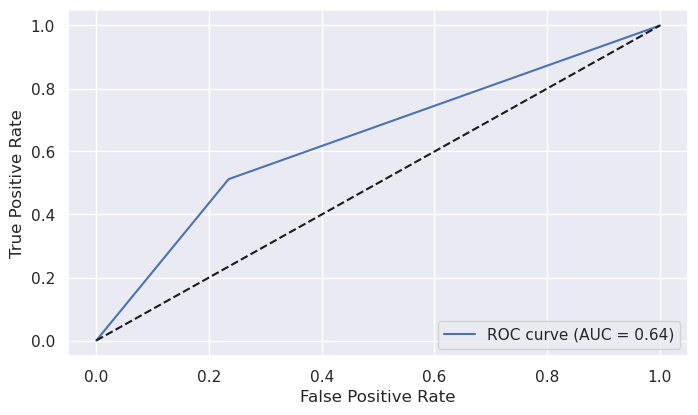

In [143]:
# | label: fig-roc_team_dif
# | fig-cap: Receiver operating characteristic curve of the home-win predictions made by a logistic regression model trained on significant team attribute differences.
 
fpr, tpr, thresholds = roc_curve(y_test, predictions_rfe.round())
auc_score = roc_auc_score(y_test, predictions_rfe.round())

fig_roc_player_rfe, ax_roc_player_rfe = plt.subplots(figsize=(base_fig_width, base_fig_height))
ax_roc_player_rfe.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % auc_score)
ax_roc_player_rfe.plot([0, 1], [0, 1], "k--")  # Random guessing line
ax_roc_player_rfe.set_xlabel("False Positive Rate")
ax_roc_player_rfe.set_ylabel("True Positive Rate")
ax_roc_player_rfe.legend(loc="lower right")
plt.show()

##### Features selected by RFE and their coefficients:

In [144]:
player_rfe_params = result_player_rfe.params[1:].to_frame(name="Coefficient")
player_rfe_params["p-value"] = result_player_rfe.pvalues[1:].values
player_rfe_params.index = rfe_selected_columns

player_rfe_params.sort_values("Coefficient", ascending=False).head().style.applymap(
    lambda value: disf.rb_cell_highlight(value, threshold=significance, higher=False),
    subset="p-value",
).format("{:.3f}")

,Coefficient,p-value
overall_rating_avg_diff,0.643,0.000
finishing_avg_diff,0.157,0.007


Using recursive feature elimination has reduced the number of features used to four (Differences in overall player rating, vision, standing tackle and sliding tackle)

#### Simple Logistic Regression

In [65]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_features_playerdif["overall_rating_avg_diff"],
    home_win_target_playerdif,
    test_size=0.33,
    random_state=1,
)

# Scaling the data
player_feat_scaler = StandardScaler()
X_train = player_feat_scaler.fit_transform(X_train.values.reshape(-1, 1))
X_test = player_feat_scaler.fit_transform(X_test.values.reshape(-1, 1))

# Fit
logreg_model_overall_rat = sm.Logit(y_train, sm.add_constant(X_train))
result_player_overall_rat = logreg_model_overall_rat.fit(disp=0)

# Predict using the trained model with selected features
predictions_overall_rat = result_player_overall_rat.predict(sm.add_constant(X_test))

# Print the predicted probabilities
print(classification_report(y_test, predictions_overall_rat.round()))


              precision    recall  f1-score   support

           0       0.66      0.76      0.71       933
           1       0.63      0.51      0.56       736

    accuracy                           0.65      1669
   macro avg       0.65      0.64      0.64      1669
weighted avg       0.65      0.65      0.65      1669



##### Model plot:

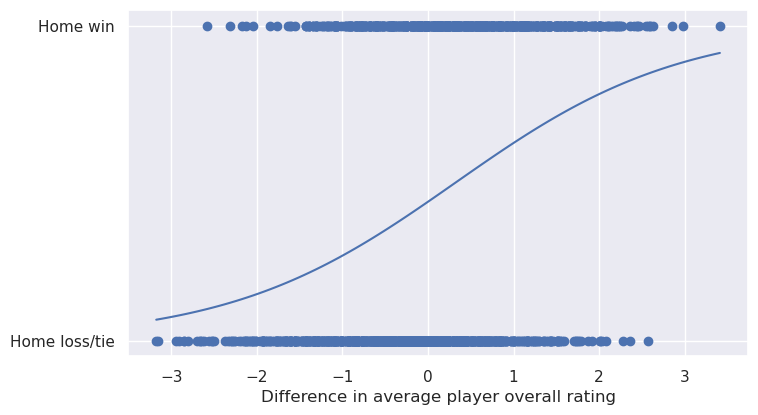

In [66]:
fig_player_log, ax_player_log = plt.subplots(figsize=(base_fig_width, base_fig_height))
x_values = np.linspace(min(X_test), max(X_test), 100)
# Calculate corresponding y-values using logistic function
y_values = 1 / (
    1
    + np.exp(
        -(
            result_player_overall_rat.params[1] * x_values
            + result_player_overall_rat.params[0]
        )
    )
)

ax_player_log.scatter(X_test, y_test)
ax_player_log.plot(x_values, y_values)
disf.axis_titles(ax_player_log, "Difference in average player overall rating")
ax_player_log.set_yticks((0, 1))
ax_player_log.set_yticklabels(("Home loss/tie", "Home win"))
plt.show()

## Game outcome prediction models

### Home win

#### Model Training and predictions

##### Creating a dataframe with all features to be used:

In [67]:
match_win_final_df = match_win_df.merge(
    home_win_features_playerdif[rfe_selected_columns], left_index=True, right_index=True
)

match_win_final_df = match_win_final_df.merge(
    home_win_team_features_dif, left_index=True, right_index=True
)


##### Fitting the model and making predictions:

In [68]:
home_win_final_target = match_win_final_df["home_team_win"]
home_win_final_features = match_win_final_df[
    team_feat_names + rfe_selected_columns.to_list()
]

# Splitting the data into training and test sets
X_train_win, X_test_win, y_train_win, y_test_win = train_test_split(
    home_win_final_features,
    home_win_final_target,
    test_size=0.33,
    random_state=1,
)

# Scaling the data
final_feat_scaler = StandardScaler()
X_train_win = player_feat_scaler.fit_transform(X_train_win)
X_test_win = player_feat_scaler.fit_transform(X_test_win)

# Create and fit the logistic regression model
logit_model_win = sm.Logit(y_train_win, sm.add_constant(X_train_win))
result_win_final = logit_model_win.fit_regularized(
    method="l1_cvxopt_cp", alpha=0.0, disp=0
)

# Predict using the trained model
predictions_win_final = result_win_final.predict(sm.add_constant(X_test_win))

#### Model evaluation:

##### Significant coefficients:

In [69]:
params_win_final = result_win_final.params[1:].to_frame(name="Coefficient")
params_win_final["p-value"] = result_win_final.pvalues[1:].values
params_win_final.index = home_win_final_features.columns

display(Markdown("Significant Coefficients:"))
display(
    params_win_final.sort_values("Coefficient", ascending=False)
    .loc[params_win_final["p-value"] < significance]
    .style.format({"Coefficient": "{:.3f}"})
)


Significant Coefficients:

,Coefficient,p-value
overall_rating_avg_diff,0.612,0.000000
vision_avg_diff,0.177,0.013564
standing_tackle_avg_diff,0.174,0.048862
sliding_tackle_avg_diff,-0.218,0.012162


##### Classification report:

In [70]:
print(classification_report(y_test_win, predictions_win_final.round()))


              precision    recall  f1-score   support

           0       0.67      0.77      0.72       933
           1       0.65      0.52      0.58       736

    accuracy                           0.66      1669
   macro avg       0.66      0.65      0.65      1669
weighted avg       0.66      0.66      0.66      1669



##### Receiver Operating Characteristic Curve:

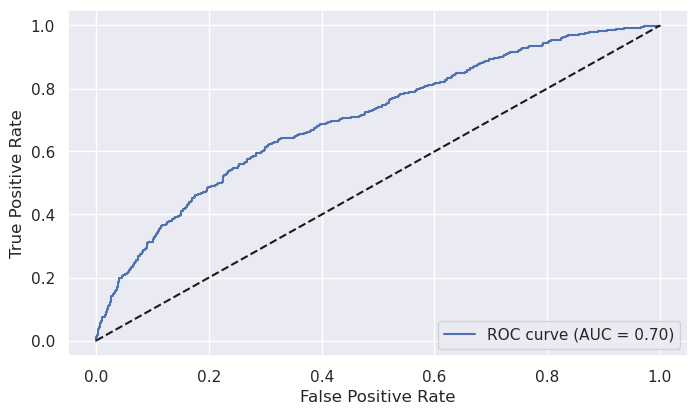

In [71]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test_win, predictions_win_final)
auc_score = roc_auc_score(y_test_win, predictions_win_final)

fig_roc, ax_roc = plt.subplots(figsize=(base_fig_width, base_fig_height))
ax_roc.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % auc_score)
ax_roc.plot([0, 1], [0, 1], "k--")  # Random guessing line
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.legend(loc="lower right")
plt.show()

### Away win

#### Modeling and predictions:

##### Preparing the home loss outcome data:

In [72]:
match_win_final_df = match_win_final_df.join(match_raw["outcome"])

match_win_final_df["w_l_t"] = match_win_final_df["outcome"].apply(
    lambda x: "Home Win" if x > 0 else ("Home Loss" if x < 0 else "Tie")
)

match_win_final_df["w_l_t"] = pd.Categorical(
    match_win_final_df["w_l_t"],
    categories=["Home Loss", "Tie", "Home Win"],
    ordered=True,
)

match_win_final_df["home_loss"] = match_win_final_df["w_l_t"].apply(
    lambda x: 1 if x == "Home Loss" else 0
)


##### Model fitting and predictions

In [73]:
home_loss_final_target = match_win_final_df["home_loss"]
home_loss_final_features = match_win_final_df[
    team_feat_names + rfe_selected_columns.to_list()
]

# Splitting the data into training and test sets
X_train_loss, X_test_loss, y_train_loss, y_test_loss = train_test_split(
    home_loss_final_features,
    home_loss_final_target,
    test_size=0.33,
    random_state=1,
)

# Scaling the data
final_feat_scaler = StandardScaler()
X_train_loss = player_feat_scaler.fit_transform(X_train_loss)
X_test_loss = player_feat_scaler.fit_transform(X_test_loss)

# Create and fit the logistic regression model
logit_model_loss = sm.Logit(y_train_loss, sm.add_constant(X_train_loss))
result_loss_final = logit_model_loss.fit_regularized(
    method="l1_cvxopt_cp", alpha=0, disp=0
)

# Predict using the trained model
predictions_loss_final = result_loss_final.predict(sm.add_constant(X_test_loss))

#### Evaluating the model

##### Coefficient importance:

In [74]:
params_loss_final = result_loss_final.params[1:].to_frame(name="Coefficient")
params_loss_final["p-value"] = result_loss_final.pvalues[1:].values
params_loss_final.index = home_loss_final_features.columns

display(Markdown("Significant Coefficients:"))
display(
    params_loss_final.sort_values("Coefficient", ascending=False)
    .loc[params_loss_final["p-value"] < significance]
    .style.format({"Coefficient": "{:.3f}"})
)


Significant Coefficients:

,Coefficient,p-value
sliding_tackle_avg_diff,0.202,0.031679
vision_avg_diff,-0.215,0.005178
overall_rating_avg_diff,-0.636,0.000000


In [75]:
print(classification_report(y_test_loss, predictions_loss_final.round()))


              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1178
           1       0.61      0.28      0.38       491

    accuracy                           0.74      1669
   macro avg       0.68      0.60      0.61      1669
weighted avg       0.71      0.74      0.70      1669



##### Receiver Operating Characteristic Curve:

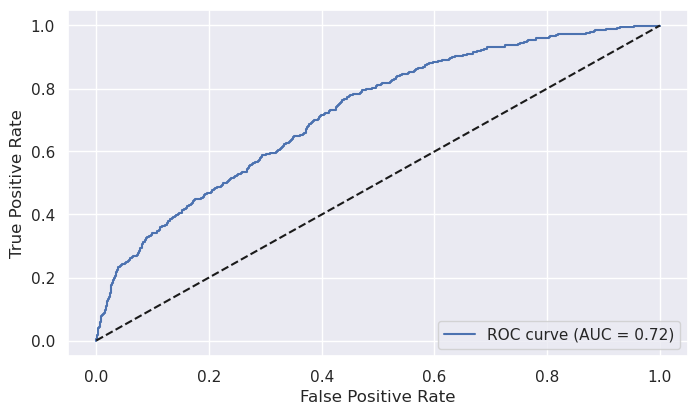

In [76]:
fpr, tpr, thresholds = roc_curve(y_test_loss, predictions_loss_final)
auc_score = roc_auc_score(y_test_loss, predictions_loss_final)

fig_roc_loss, ax_roc_loss = plt.subplots(figsize=(base_fig_width, base_fig_height))
ax_roc_loss.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % auc_score)
ax_roc_loss.plot([0, 1], [0, 1], "k--")  # Random guessing line
ax_roc_loss.set_xlabel("False Positive Rate")
ax_roc_loss.set_ylabel("True Positive Rate")
ax_roc_loss.legend(loc="lower right")
plt.show()


### Win-Loss-Tie Classification

#### Ordinal Model

In [77]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

home_win_final_target = match_win_final_df["w_l_t"]
home_win_final_features = match_win_final_df[
    team_feat_names + rfe_selected_columns.to_list()
]

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_final_features,
    home_win_final_target,
    test_size=0.33,
    random_state=1,
)

# Scaling the data
final_feat_scaler = StandardScaler()
X_train = player_feat_scaler.fit_transform(X_train)
X_test = player_feat_scaler.fit_transform(X_test)

# Create and fit the logistic regression model
ordered_log_model = OrderedModel(y_train, X_train)
result_multi_logit = ordered_log_model.fit(maxiter=10000)

# Predict using the trained model
predictions_wlt = result_multi_logit.predict(X_test)

# Print the predicted probabilities
print(classification_report(np.asarray(y_test.values.codes), predictions_wlt.argmax(1)))

Optimization terminated successfully.
         Current function value: 0.990864
         Iterations: 3516
         Function evaluations: 4596
              precision    recall  f1-score   support

           0       0.48      0.53      0.50       491
           1       0.00      0.00      0.00       442
           2       0.52      0.80      0.63       736

    accuracy                           0.51      1669
   macro avg       0.33      0.44      0.38      1669
weighted avg       0.37      0.51      0.43      1669



#### Custom Classification based on home win and home loss probabilities:

##### Calculating win and loss probabilities for the training set:

In [78]:
predicts_both = pd.DataFrame(
    {
        "win": result_win_final.predict(sm.add_constant(X_train_win)),
        "loss": result_loss_final.predict(sm.add_constant(X_train_loss)),
    }
)


In [79]:
params = Parameters()
params.add("coef_a", value=0.1, min=0.01, max=0.5)
params.add("coef_b", value=0.25, min=0.01, max=0.5)
minner = Minimizer(classifier_train_prob_dif, params, fcn_args=(predicts_both, y_train))
result_final_class = minner.minimize(method="basinhopping")

In [80]:
result_final_class


In [81]:
final_predict = pd.DataFrame(
    {"win": predictions_win_final, "loss": predictions_loss_final}
)

final_predict["guess"] = predicts_both.apply(
    outcome_guess_prob_dif,
    axis=1,
    args=(
        result_final_class.params["coef_a"].value,
        result_final_class.params["coef_b"].value,
    ),
)

print(classification_report(y_test, final_predict["guess"]))

              precision    recall  f1-score   support

   Home Loss       0.32      0.29      0.31       491
    Home Win       0.44      0.67      0.53       736
         Tie       0.29      0.06      0.10       442

    accuracy                           0.40      1669
   macro avg       0.35      0.34      0.31      1669
weighted avg       0.36      0.40      0.35      1669



#### Custom classification based on home-win probabilities

In [82]:
params_prob = Parameters()
params_prob.add("coef_win", value=0.1, min=0.1, max=0.5)
params_prob.add("coef_loss", value=0.25, min=0.1, max=0.5)
minner = Minimizer(
    classifier_train_prob_win, params_prob, fcn_args=(predicts_both["win"], y_train)
)
result_final_class = minner.minimize(method="basinhopping")

In [83]:
final_pred = pd.Series(predictions_win_final).apply(
    outcome_guess_prob_win,
    args=(
        result_final_class.params["coef_win"].value,
        result_final_class.params["coef_loss"].value,
    ),
)

print(classification_report(y_test, final_pred))

              precision    recall  f1-score   support

   Home Loss       0.43      0.75      0.54       491
    Home Win       0.64      0.52      0.58       736
         Tie       0.31      0.14      0.20       442

    accuracy                           0.49      1669
   macro avg       0.46      0.47      0.44      1669
weighted avg       0.49      0.49      0.47      1669



Linear model

In [100]:
player_att_dict = {}
for i in match_win_df_player.index:
    player_att_dict[i] = match_win_df_player.at[
        i, "match_players"
    ].export_player_attributes(player_attr_numeric, how="avg")

goals_df = pd.DataFrame.from_dict(player_att_dict, orient="index")

# Dropping rows with missing values
goals_df.dropna(inplace=True)

# In some cases missing attributes were returned as empty dictionaries, dropping these rows
goals_df = goals_df[
    goals_df.apply(
        lambda x: False if dict in [type(i) for i in x.values] else True, axis=1
    )
]

goals_df = goals_df.join(match_raw["outcome"])
goals_df = goals_df.astype(int)
goals_df = goals_df.drop(
    columns=[
        "overall_rating_H_avg",
        "potential_H_avg",
        "overall_rating_A_avg",
        "potential_A_avg",
        "overall_rating_H_gk",
        "potential_H_gk",
        "overall_rating_A_gk",
        "potential_A_gk",
    ]
)


#### Dropping observationally useless stats

##### Regular player goal keeping stats:

In [101]:
player_gk_stats = [i for i in goals_df.columns if (i[:2] == "gk" and i[-2:] != "gk")]
goals_df = goals_df.drop(columns=player_gk_stats)


##### Irrelevant goal keeper stats based on average values being low:

In [102]:
irrelevant_gk_stats = (
    goals_df[[i for i in goals_df.columns if i[-2:] == "gk"]]
    .mean()[goals_df[[i for i in goals_df.columns if i[-2:] == "gk"]].mean() < 30]
    .index.to_list()
)

goals_df = goals_df.drop(columns=irrelevant_gk_stats)

#### Dropping strong linear correlations

In [103]:
disf.get_correlation_pairs(goals_df, 0.9, -0.9)

,r-value,feature_pair
0,0.928173,"(short_passing_H_avg, long_passing_H_avg)"
1,0.946143,"(short_passing_H_avg, ball_control_H_avg)"
2,0.908599,"(short_passing_H_avg, reactions_H_avg)"
3,0.914209,"(ball_control_H_avg, dribbling_H_avg)"
7,0.910845,"(ball_control_H_avg, reactions_H_avg)"
10,0.938733,"(sliding_tackle_H_avg, standing_tackle_H_avg)"
12,0.903585,"(gk_diving_H_gk, gk_reflexes_H_gk)"
14,0.928766,"(long_passing_A_avg, short_passing_A_avg)"
15,0.942833,"(ball_control_A_avg, short_passing_A_avg)"
16,0.908592,"(reactions_A_avg, short_passing_A_avg)"


In [104]:
# Cluster 1 summarized by ball_control
corr_to_drop = [
    "long_passing_H_avg",
    "short_passing_H_avg",
    "reactions_H_avg",
    "dribbling_H_avg",
    "long_passing_A_avg",
    "short_passing_A_avg",
    "reactions_A_avg",
    "dribbling_A_avg",
]

# Cluster 2 sliding/standing tackles
corr_to_drop.extend(["sliding_tackle_H_avg", "standing_tackle_A_avg"])

# Cluster 3 gk reflexes/diving
corr_to_drop.extend(["gk_diving_H_gk", "gk_diving_A_gk"])

goals_df = goals_df.drop(columns=corr_to_drop)

In [117]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    goals_df.drop(columns="outcome"),
    goals_df["outcome"],
    test_size=0.33,
    random_state=1,
)

# Scaling the data
team_feat_scaler = StandardScaler()
X_train = team_feat_scaler.fit_transform(X_train)
X_test = team_feat_scaler.fit_transform(X_test)

from sklearn.linear_model import LinearRegression

lin_reg_pre_rfe = LinearRegression()
lin_rfe = RFECV(lin_reg_pre_rfe, step=1, cv=10)
lin_rfe = lin_rfe.fit(X_train, y_train)

# Create and fit the logistic regression model
goal_model_all = sm.OLS(y_train, sm.add_constant(X_train[:, lin_rfe.support_]))
result_goal_all = goal_model_all.fit()

# Predict using the trained model
predictions_goal_all = result_goal_all.predict(
    sm.add_constant(X_test[:, lin_rfe.support_])
)

In [118]:
params_goal_all = pd.DataFrame(
    {
        "Coefficient": result_goal_all.params[1:].values,
        "p-value": result_goal_all.pvalues[1:].values,
    },
    # index=goals_df.drop(columns="outcome").columns,
    index=goals_df.drop(columns="outcome").columns[lin_rfe.support_],
)

params_goal_all.loc[params_goal_all["p-value"] < significance].sort_values(
    "Coefficient", key=lambda x: abs(x), ascending=False
)

,Coefficient,p-value
ball_control_A_avg,-0.509957,6.474667e-16
ball_control_H_avg,0.486730,1.379674e-13
vision_H_avg,0.194598,2.354334e-03
finishing_H_avg,0.171463,8.903101e-04
stamina_A_avg,-0.156420,4.179071e-05
crossing_A_avg,-0.144600,7.165704e-03


<Axes: ylabel='Count'>

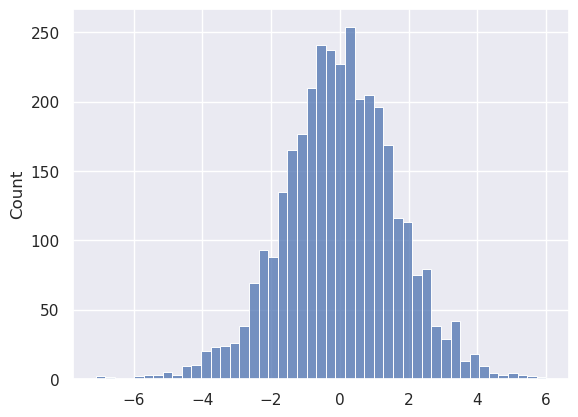

In [108]:
sns.histplot(result_goal_all.resid)


In [109]:
np.sqrt(((y_test - predictions_goal_all) ** 2).sum() / len(y_test))

1.6355887717510031

              precision    recall  f1-score   support

          -6       0.00      0.00      0.00         4
          -5       0.00      0.00      0.00         3
          -4       0.00      0.00      0.00        20
          -3       0.00      0.00      0.00        52
          -2       0.24      0.04      0.07       137
          -1       0.27      0.24      0.26       275
           0       0.30      0.50      0.37       442
           1       0.23      0.37      0.28       322
           2       0.25      0.16      0.19       222
           3       0.20      0.01      0.02       117
           4       0.00      0.00      0.00        52
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2

    accuracy                           0.27      1669
   macro avg       0.10      0.09      0.08      1669
weighted avg       0.23   

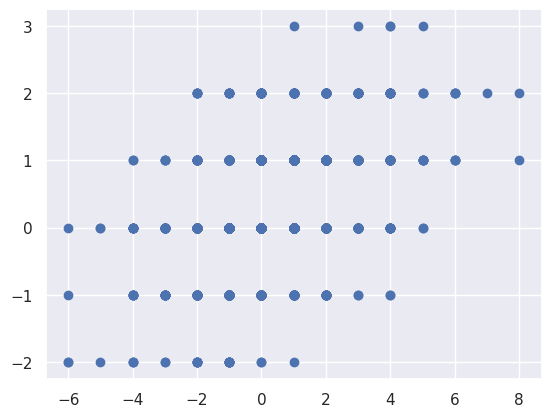

In [110]:
plt.scatter(y_test, predictions_goal_all.round())
print(classification_report(y_test, predictions_goal_all.round()))

<Axes: >

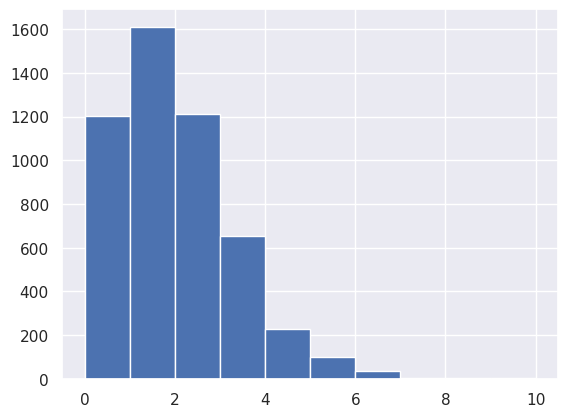

In [99]:
goals_df["home_team_goal"].hist()

In [98]:
result_goal_all.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         home_team_goal   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     46.77
Date:                Thu, 20 Jul 2023   Prob (F-statistic):          1.29e-103
Time:                        10:15:12   Log-Likelihood:                -5463.2
No. Observations:                3386   AIC:                         1.095e+04
Df Residuals:                    3373   BIC:                         1.103e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5162      0.021     72.493      0.000       1.475       1.557
x1             0.0777      0.042      1.855      0.064      -0.004       0.160
x2             0.1159      0.040      2.871      0.004       0.037       0.195
x3             0.0846      0.054      1.576      0.115      -0.021       0.190
x4             0.0764      0.026      2.917      0.004       0.025       0.128
x5             0.1877      0.048      3.891      0.000       0.093       0.282
x6             0.0740      0.022      3.394      0.001       0.031       0.117
x7            -0.1355      0.042     -3.225      0.001      -0.218      -0.053
x8            -0.0603      0.046     -1.322      0.186      -0.150       0.029
x9            -0.1489      0.059     -2.532      0.011      -0.264      -0.034
x10           -0.0961      0.028     -3.379      0.001      -0.152      -0.040
x11            0.1016      0.042      2.435      0.015       0.020       0.183
x12           -0.1177      0.031     -3.822      0.000      -0.178      -0.057
==============================================================================
Omnibus:                      334.058   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              472.935
Skew:                           0.772   Prob(JB):                    2.01e-103
Kurtosis:                       3.984   Cond. No.                         8.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Summary